<a href="https://colab.research.google.com/github/jnunez03/SQL/blob/master/ConversionFromPaywallFinalized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img alt="Colaboratory logo" height="45px" src="https://colab.research.google.com/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

<h1>Conversion from Paywall</h1>   

In [68]:
import pandas as pd
import pandas_profiling
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb
from pandas import Series, DataFrame
from pylab import *
import statsmodels.api as sm
from matplotlib.ticker import MaxNLocator
from matplotlib.font_manager import FontProperties
from scipy import stats
from scipy.stats import norm
from fbprophet import Prophet
import logging

logger = logging.getLogger('pandas_gbq')
logger.propagate = False 
logging.getLogger().disabled = True

#  Use ET2 From September Forward  -->  09/01 To [current date]
q = """
SELECT 
day,format_datetime('%A',cast(day as datetime)) as dayName, count(distinct p.user_id) as paywall, count(distinct c.regi_id) as converts
FROM `nyt-bigquery-beta-workspace.nunez_justin.NonSubsWhoHitPayWall` p
left join `nyt-eventtracker-prd.et_derived.thank_you_events` c ON cast(c.regi_id as string) = p.user_id and date(p.date_hit_paywall) = date(c.signup_date) and c.bundle = 'CK'
group by 1,2
order by 1 asc 
"""

# importing the data
df = pd.read_gbq(q,
    project_id = 'nyt-bigquery-beta-workspace',
    dialect='standard')


# Descriptive statistics, data type, data preview 
print(df.describe(), ' \n \n', '*Data Types Below* \n \n', df.dtypes ,' \n \n', df.head(n=6))

            paywall    converts
count     63.000000   63.000000
mean   20163.587302  328.142857
std     6640.959313  119.080599
min    10064.000000  160.000000
25%    14802.500000  230.500000
50%    20028.000000  301.000000
75%    24522.500000  417.500000
max    39744.000000  680.000000  
 
 *Data Types Below* 
 
 day         datetime64[ns]
dayName             object
paywall              int64
converts             int64
dtype: object  
 
          day    dayName  paywall  converts
0 2019-09-01     Sunday    18329       316
1 2019-09-02     Monday    20464       311
2 2019-09-03    Tuesday    17313       215
3 2019-09-04  Wednesday    16419       223
4 2019-09-05   Thursday    10064       160
5 2019-09-06     Friday    13323       198


In [0]:
#pandas_profiling.ProfileReport(df)


In [69]:
# make sure date is of datetime. 
df['day'] = pd.to_datetime(df['day'])
 
df.dtypes   

day         datetime64[ns]
dayName             object
paywall              int64
converts             int64
dtype: object

In [0]:
# Assuming our users is proper denominator. 

df['Conversion'] = df.apply(lambda row: (row.converts / row.paywall) * 100, axis=1)     # -- >  axis=1 or ‘columns’: apply function to each row.

In [72]:
df.head(n=60)    # index from 0
#df.describe()

,day,dayName,paywall,converts,Conversion
0,2019-09-01,Sunday,18329,316,1.724044
1,2019-09-02,Monday,20464,311,1.519742
2,2019-09-03,Tuesday,17313,215,1.241841
3,2019-09-04,Wednesday,16419,223,1.358183
4,2019-09-05,Thursday,10064,160,1.589825
5,2019-09-06,Friday,13323,198,1.486152
6,2019-09-07,Saturday,28145,481,1.709007
7,2019-09-08,Sunday,21560,433,2.008349
8,2019-09-09,Monday,22320,349,1.563620
9,2019-09-10,Tuesday,12601,227,1.801444


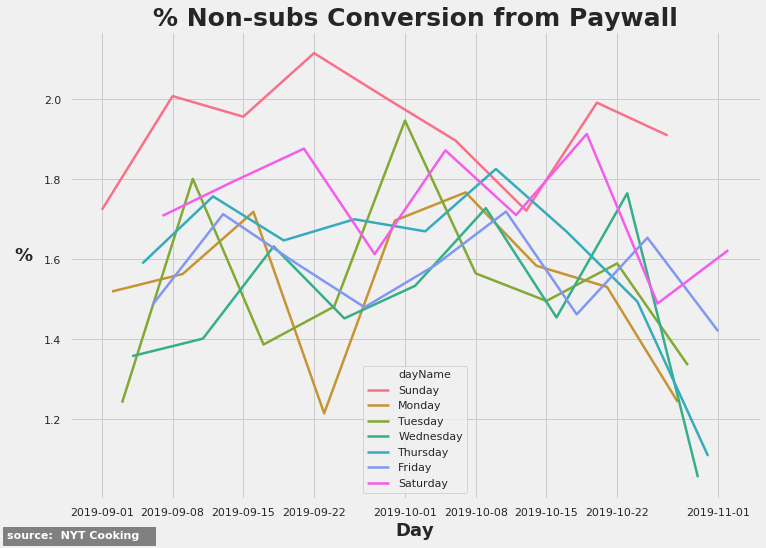

In [73]:
%matplotlib inline
plt.style.use('fivethirtyeight')
#plt.style.use('bmh')   #bmh, ggplot,seaborn-notebook,seaborn-deep,dark_background
rcParams['figure.figsize'] = 11,8

sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})
sb.lineplot(x="day", y="Conversion", hue="dayName", data=df)   # Percent Hit WALL 
#sb.lineplot(x="day", y="paywall", hue="dayName", data=df)   # Number Hit Wall 
plt.title('% Non-subs Conversion from Paywall',fontsize=25,weight='bold')
plt.ylabel('%     ', fontsize=18, rotation=0, weight='bold')
plt.xlabel('Day',fontsize=18, weight='bold')
#plt.text(x=1, y=1000, s='NYT Cooking', fontsize=9, color='#f0f0f0',backgroundcolor='grey')
plt.figtext(0, 0,'source:  NYT Cooking   ', fontsize=11, color='white',backgroundcolor='grey',weight= 'bold') #rotation=0, #color='black')
plt.show() 

**Don't run the below code until after everything else**

In [0]:
df['paywallAvg'] = df['paywall'].mean()
df['convertsAvg'] = df['converts'].mean()
df['conversionAvg'] = df['Conversion'].mean()

df.head(n=6)

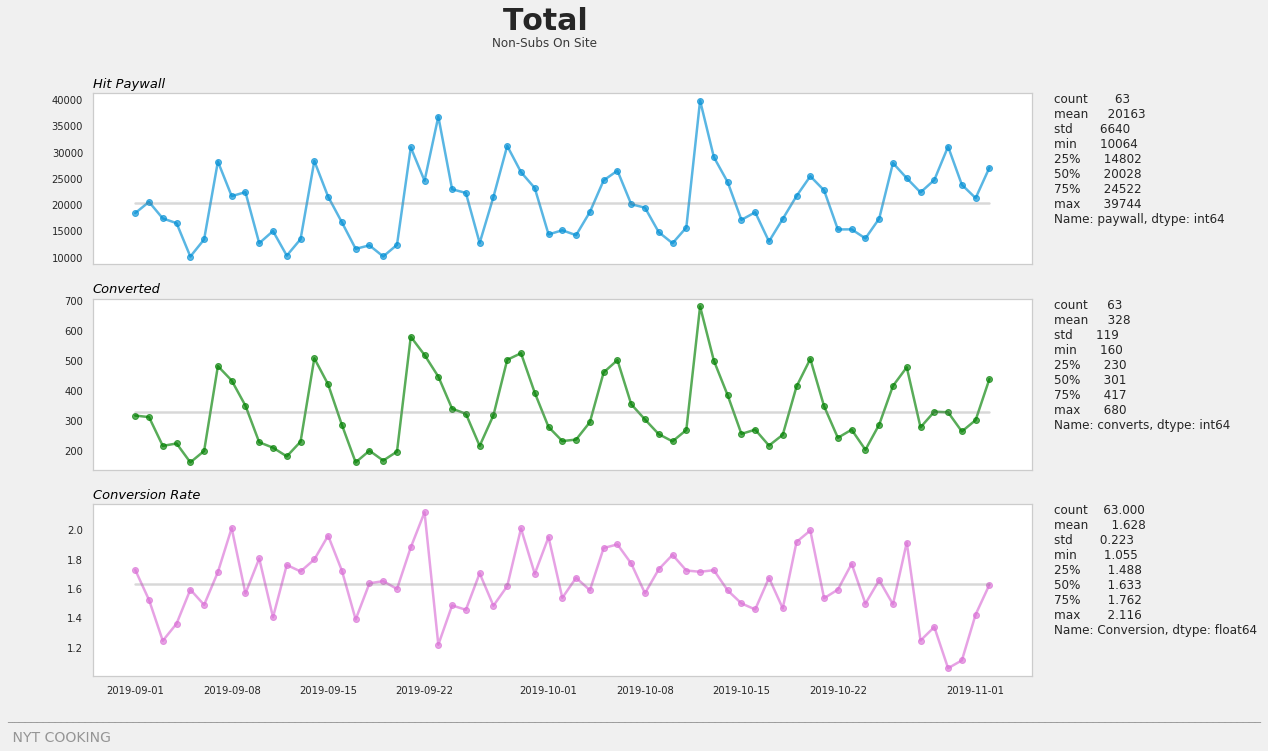

In [56]:
%matplotlib inline
from matplotlib.ticker import MaxNLocator
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 15,10
sb.despine()
#sb.set(font_scale = .8)
sb.set_style("whitegrid", {'axes.grid' : False})
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

#      ---->      Hit paywall and # converted
# df
m = df["paywall"].describe().astype(int)
soa = str(m)

mo = df["converts"].describe().astype(int)
moa = str(mo)

moo = df["Conversion"].describe().round(3)
moaa = str(moo)

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3)
ax1.plot('day', 'paywall', data=df, marker='o', alpha=0.65)
#average
ax1.plot('day', 'paywallAvg', data=df, alpha=0.30,color='grey')
plt.title('Hit Paywall', fontsize=13, color='black', loc='left', style='italic')
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.tick_params(axis = 'y', which = 'major', labelsize = 10)


ax2 = plt.subplot2grid((3, 3), (1, 0), colspan=3)
ax2.plot('day','converts', data=df, marker='o', color="green", alpha=0.65)
#average
ax2.plot('day', 'convertsAvg', data=df, alpha=0.3,color='grey')
plt.title('Converted', fontsize=13, color='black', loc='left', style='italic')
plt.setp(ax2.get_xticklabels(), visible=False)
ax2.tick_params(axis = 'y', which = 'major', labelsize = 10)

ax3 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
ax3.plot('day','Conversion', data=df, marker='o', color="orchid", alpha=0.65) #turquoise
#average
ax3.plot('day', 'conversionAvg', data=df, alpha=0.3,color='grey')
plt.title('Conversion Rate', fontsize= 13, color='black', loc='left', style='italic')
ax3.tick_params(axis = 'both', which = 'major', labelsize = 10)

plt.suptitle('Total', y=1.0,fontsize=30,weight='bold')
plt.figtext(.97, .70,soa)
plt.figtext(.97, .414,moa)
plt.figtext(.97, .13,moaa)
plt.figtext(x = 0.001, y = .01,
    s = '_________________________________________________________________________________________________________________________________________________________________________________________________________________',
    color = 'grey', alpha = .75)
plt.figtext(x = 0.0013, y = -.020,
    s = ' NYT COOKING',
    fontsize = 14, color = 'grey', alpha = .81)
plt.figtext(x = .45, y = .945,
               s = 'Non-Subs On Site',
              fontsize = 12, alpha = .90)
plt.show()

In [0]:
dfMon = df[df['dayName'] == 'Monday']

dfTue = df[df['dayName'] == 'Tuesday']

dfWed = df[df['dayName'] == 'Wednesday']

dfThurs = df[df['dayName'] == 'Thursday']

dfFri =  df[df['dayName'] == 'Friday']

dfSat = df[df['dayName'] == 'Saturday']

dfSun = df[df['dayName'] == 'Sunday'] 

# Monday :) 


In [0]:
dfMon['paywallAvg'] = dfMon['paywall'].mean()
dfMon['convertsAvg'] = dfMon['converts'].mean()
dfMon['conversionAvg'] = dfMon['Conversion'].mean()

dfMon.head(n=6)

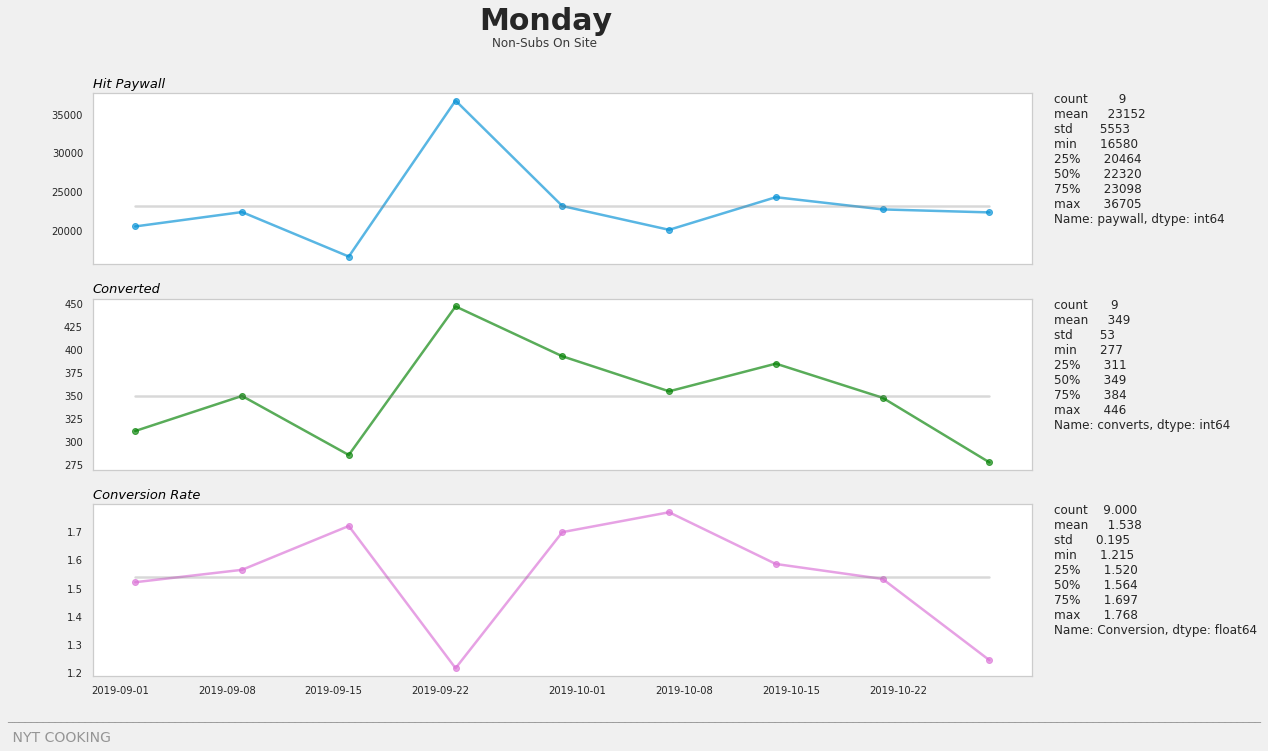

In [76]:
%matplotlib inline
from matplotlib.ticker import MaxNLocator
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 15,10
sb.despine()
#sb.set(font_scale = .8)
sb.set_style("whitegrid", {'axes.grid' : False})
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

#      ---->      Hit paywall and # converted
# dfMon
mon = dfMon["paywall"].describe().astype(int)
s2 = str(mon)

mon2 = dfMon["converts"].describe().astype(int)
mon22 = str(mon2)

mon3 = dfMon["Conversion"].describe().round(3)
mon33 = str(mon3)

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3)
ax1.plot('day', 'paywall', data=dfMon, marker='o', alpha=0.65)
#average
ax1.plot('day', 'paywallAvg', data=dfMon, alpha=0.30,color='grey')
plt.title('Hit Paywall', fontsize=13, color='black', loc='left', style='italic')
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.tick_params(axis = 'y', which = 'major', labelsize = 10)


ax2 = plt.subplot2grid((3, 3), (1, 0), colspan=3)
ax2.plot('day','converts', data=dfMon, marker='o', color="green", alpha=0.65)
#average
ax2.plot('day', 'convertsAvg', data=dfMon, alpha=0.3,color='grey')
plt.title('Converted', fontsize=13, color='black', loc='left', style='italic')
plt.setp(ax2.get_xticklabels(), visible=False)
ax2.tick_params(axis = 'y', which = 'major', labelsize = 10)

ax3 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
ax3.plot('day','Conversion', data=dfMon, marker='o', color="orchid", alpha=0.65) #turquoise
#average
ax3.plot('day', 'conversionAvg', data=dfMon, alpha=0.3,color='grey')
plt.title('Conversion Rate', fontsize= 13, color='black', loc='left', style='italic')
ax3.tick_params(axis = 'both', which = 'major', labelsize = 10)

plt.suptitle('Monday', y=1.0,fontsize=30,weight='bold')
plt.figtext(.97, .70,s2)
plt.figtext(.97, .414,mon22)
plt.figtext(.97, .13,mon33)
plt.figtext(x = 0.001, y = .01,
    s = '_________________________________________________________________________________________________________________________________________________________________________________________________________________',
    color = 'grey', alpha = .75)
plt.figtext(x = 0.0013, y = -.020,
    s = ' NYT COOKING',
    fontsize = 14, color = 'grey', alpha = .81)
plt.figtext(x = .45, y = .945,
               s = 'Non-Subs On Site',
              fontsize = 12, alpha = .90)
plt.show()

<h1> Tuesday  :) <h1> 
  

In [0]:
dfTue['paywallAvg'] = dfTue['paywall'].mean()
dfTue['convertsAvg'] = dfTue['converts'].mean()
dfTue['conversionAvg'] = dfTue['Conversion'].mean()

dfTue.head(n=6)

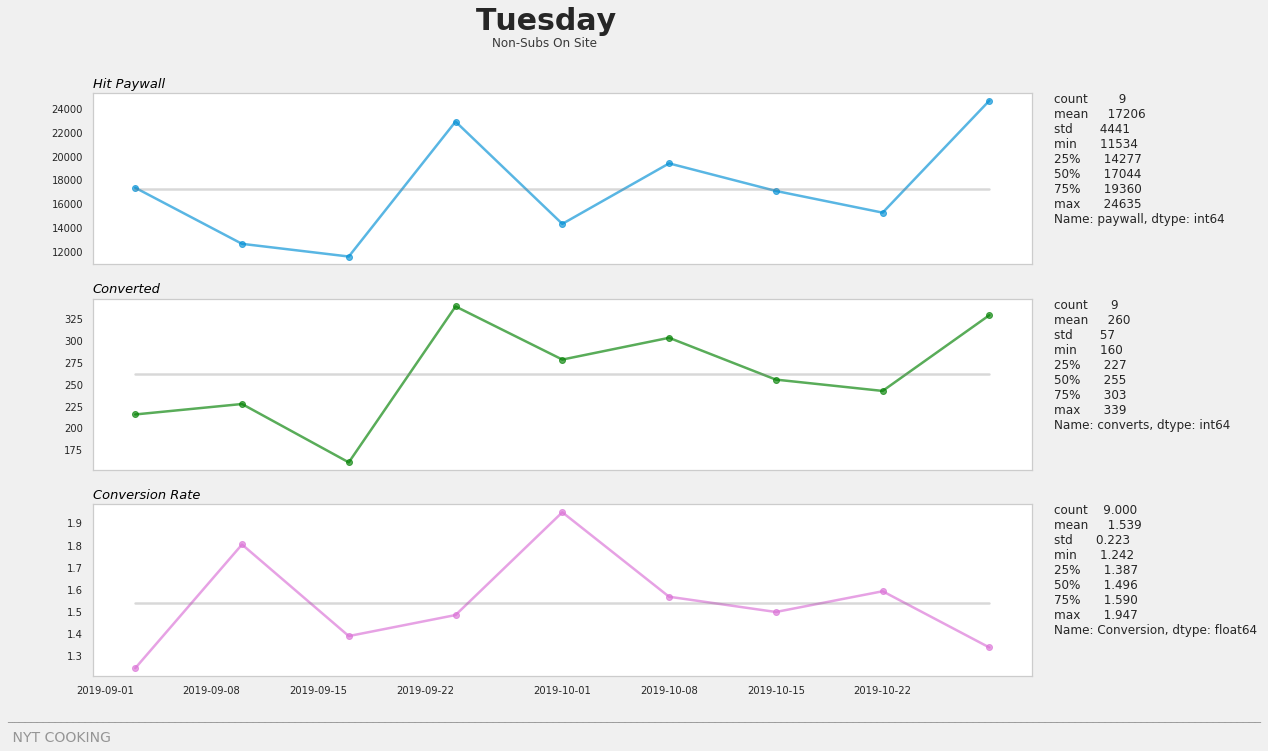

In [78]:
%matplotlib inline
from matplotlib.ticker import MaxNLocator
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 15,10
sb.despine()
#sb.set(font_scale = .8)
sb.set_style("whitegrid", {'axes.grid' : False})
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

#      ---->      Hit paywall and # converted
# dfTue
Tue = dfTue["paywall"].describe().astype(int)
Tue1 = str(Tue)

Tue2 = dfTue["converts"].describe().astype(int)
Tue22 = str(Tue2)

Tue3 = dfTue["Conversion"].describe().round(3)
Tue33 = str(Tue3)

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3)
ax1.plot('day', 'paywall', data=dfTue, marker='o', alpha=0.65)
#average
ax1.plot('day', 'paywallAvg', data=dfTue, alpha=0.30,color='grey')
plt.title('Hit Paywall', fontsize=13, color='black', loc='left', style='italic')
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.tick_params(axis = 'y', which = 'major', labelsize = 10)


ax2 = plt.subplot2grid((3, 3), (1, 0), colspan=3)
ax2.plot('day','converts', data=dfTue, marker='o', color="green", alpha=0.65)
#average
ax2.plot('day', 'convertsAvg', data=dfTue, alpha=0.3,color='grey')
plt.title('Converted', fontsize=13, color='black', loc='left', style='italic')
plt.setp(ax2.get_xticklabels(), visible=False)
ax2.tick_params(axis = 'y', which = 'major', labelsize = 10)

ax3 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
ax3.plot('day','Conversion', data=dfTue, marker='o', color="orchid", alpha=0.65) #turquoise
#average
ax3.plot('day', 'conversionAvg', data=dfTue, alpha=0.3,color='grey')
plt.title('Conversion Rate', fontsize= 13, color='black', loc='left', style='italic')
ax3.tick_params(axis = 'both', which = 'major', labelsize = 10)

plt.suptitle('Tuesday', y=1.0,fontsize=30,weight='bold')
plt.figtext(.97, .70,Tue1)
plt.figtext(.97, .414,Tue22)
plt.figtext(.97, .13,Tue33)
plt.figtext(x = 0.001, y = .01,
    s = '_________________________________________________________________________________________________________________________________________________________________________________________________________________',
    color = 'grey', alpha = .75)
plt.figtext(x = 0.0013, y = -.020,
    s = ' NYT COOKING',
    fontsize = 14, color = 'grey', alpha = .81)
plt.figtext(x = .45, y = .945,
               s = 'Non-Subs On Site',
              fontsize = 12, alpha = .90)
plt.show()


<h1> Wednesday  :) <h1> 

In [0]:
dfWed['paywallAvg'] = dfWed['paywall'].mean()
dfWed['convertsAvg'] = dfWed['converts'].mean()
dfWed['conversionAvg'] = dfWed['Conversion'].mean()

dfWed.head(n=6)

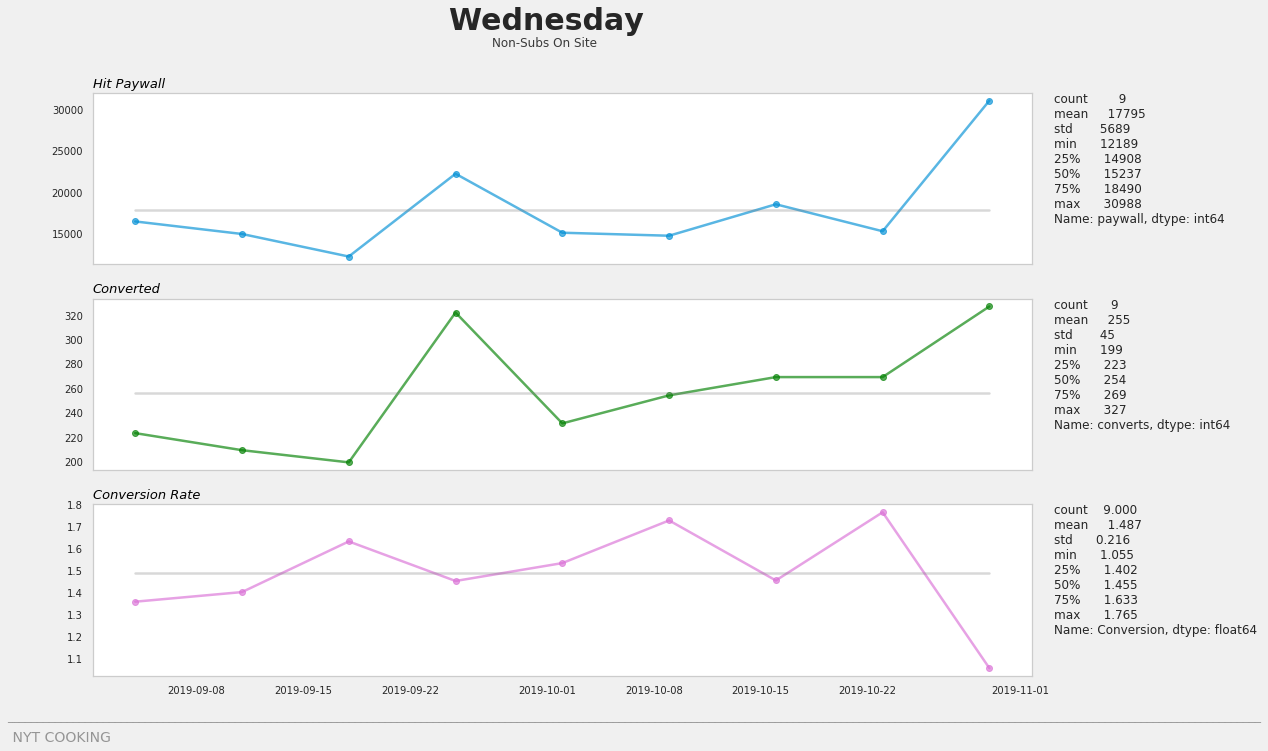

In [80]:
%matplotlib inline
from matplotlib.ticker import MaxNLocator
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 15,10
sb.despine()
#sb.set(font_scale = .8)
sb.set_style("whitegrid", {'axes.grid' : False})
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

#      ---->      Hit paywall and # converted
# dfWed
Wed = dfWed["paywall"].describe().astype(int)
Wed1 = str(Wed)

Wed2 = dfWed["converts"].describe().astype(int)
Wed22 = str(Wed2)

Wed3 = dfWed["Conversion"].describe().round(3)
Wed33 = str(Wed3)

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3)
ax1.plot('day', 'paywall', data=dfWed, marker='o', alpha=0.65)
#average
ax1.plot('day', 'paywallAvg', data=dfWed, alpha=0.30,color='grey')
plt.title('Hit Paywall', fontsize=13, color='black', loc='left', style='italic')
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.tick_params(axis = 'y', which = 'major', labelsize = 10)


ax2 = plt.subplot2grid((3, 3), (1, 0), colspan=3)
ax2.plot('day','converts', data=dfWed, marker='o', color="green", alpha=0.65)
#average
ax2.plot('day', 'convertsAvg', data=dfWed, alpha=0.3,color='grey')
plt.title('Converted', fontsize=13, color='black', loc='left', style='italic')
plt.setp(ax2.get_xticklabels(), visible=False)
ax2.tick_params(axis = 'y', which = 'major', labelsize = 10)

ax3 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
ax3.plot('day','Conversion', data=dfWed, marker='o', color="orchid", alpha=0.65) #turquoise
#average
ax3.plot('day', 'conversionAvg', data=dfWed, alpha=0.3,color='grey')
plt.title('Conversion Rate', fontsize= 13, color='black', loc='left', style='italic')
ax3.tick_params(axis = 'both', which = 'major', labelsize = 10)

plt.suptitle('Wednesday', y=1.0,fontsize=30,weight='bold')
plt.figtext(.97, .70,Wed1)
plt.figtext(.97, .414,Wed22)
plt.figtext(.97, .13,Wed33)
plt.figtext(x = 0.001, y = .01,
    s = '_________________________________________________________________________________________________________________________________________________________________________________________________________________',
    color = 'grey', alpha = .75)
plt.figtext(x = 0.0013, y = -.020,
    s = ' NYT COOKING',
    fontsize = 14, color = 'grey', alpha = .81)
plt.figtext(x = .45, y = .945,
               s = 'Non-Subs On Site',
              fontsize = 12, alpha = .90)
plt.show()

<h1> Thursday :) <h1> 

In [0]:
dfThurs['paywallAvg'] = dfThurs['paywall'].mean()
dfThurs['convertsAvg'] = dfThurs['converts'].mean()
dfThurs['conversionAvg'] = dfThurs['Conversion'].mean()

dfThurs.head(n=6)

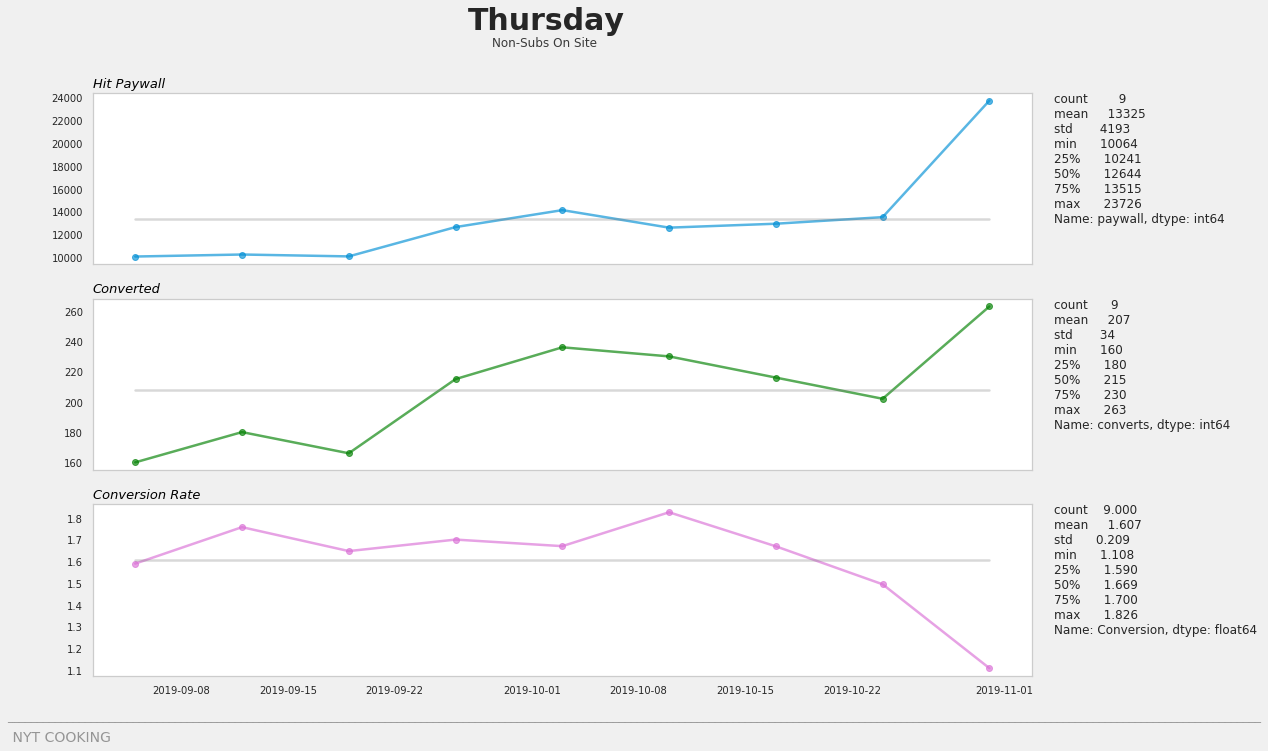

In [82]:
%matplotlib inline
from matplotlib.ticker import MaxNLocator
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 15,10
sb.despine()
#sb.set(font_scale = .8)
sb.set_style("whitegrid", {'axes.grid' : False})
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

#      ---->      Hit paywall and # converted
# dfThurs
Thurs = dfThurs["paywall"].describe().astype(int)
Thurs1 = str(Thurs)

Thurs2 = dfThurs["converts"].describe().astype(int)
Thurs22 = str(Thurs2)

Thurs3 = dfThurs["Conversion"].describe().round(3)
Thurs33 = str(Thurs3)

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3)
ax1.plot('day', 'paywall', data=dfThurs, marker='o', alpha=0.65)
#average
ax1.plot('day', 'paywallAvg', data=dfThurs, alpha=0.30,color='grey')
plt.title('Hit Paywall', fontsize=13, color='black', loc='left', style='italic')
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.tick_params(axis = 'y', which = 'major', labelsize = 10)


ax2 = plt.subplot2grid((3, 3), (1, 0), colspan=3)
ax2.plot('day','converts', data=dfThurs, marker='o', color="green", alpha=0.65)
#average
ax2.plot('day', 'convertsAvg', data=dfThurs, alpha=0.3,color='grey')
plt.title('Converted', fontsize=13, color='black', loc='left', style='italic')
plt.setp(ax2.get_xticklabels(), visible=False)
ax2.tick_params(axis = 'y', which = 'major', labelsize = 10)

ax3 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
ax3.plot('day','Conversion', data=dfThurs, marker='o', color="orchid", alpha=0.65) #turquoise
#average
ax3.plot('day', 'conversionAvg', data=dfThurs, alpha=0.3,color='grey')
plt.title('Conversion Rate', fontsize= 13, color='black', loc='left', style='italic')
ax3.tick_params(axis = 'both', which = 'major', labelsize = 10)

plt.suptitle('Thursday', y=1.0,fontsize=30,weight='bold')
plt.figtext(.97, .70,Thurs1)
plt.figtext(.97, .414,Thurs22)
plt.figtext(.97, .13,Thurs33)
plt.figtext(x = 0.001, y = .01,
    s = '_________________________________________________________________________________________________________________________________________________________________________________________________________________',
    color = 'grey', alpha = .75)
plt.figtext(x = 0.0013, y = -.020,
    s = ' NYT COOKING',
    fontsize = 14, color = 'grey', alpha = .81)
plt.figtext(x = .45, y = .945,
               s = 'Non-Subs On Site',
              fontsize = 12, alpha = .90)
plt.show()

<h1> Friday :) <h1> 

In [0]:
dfFri['paywallAvg'] = dfFri['paywall'].mean()
dfFri['convertsAvg'] = dfFri['converts'].mean()
dfFri['conversionAvg'] = dfFri['Conversion'].mean()

dfFri.head(n=6)

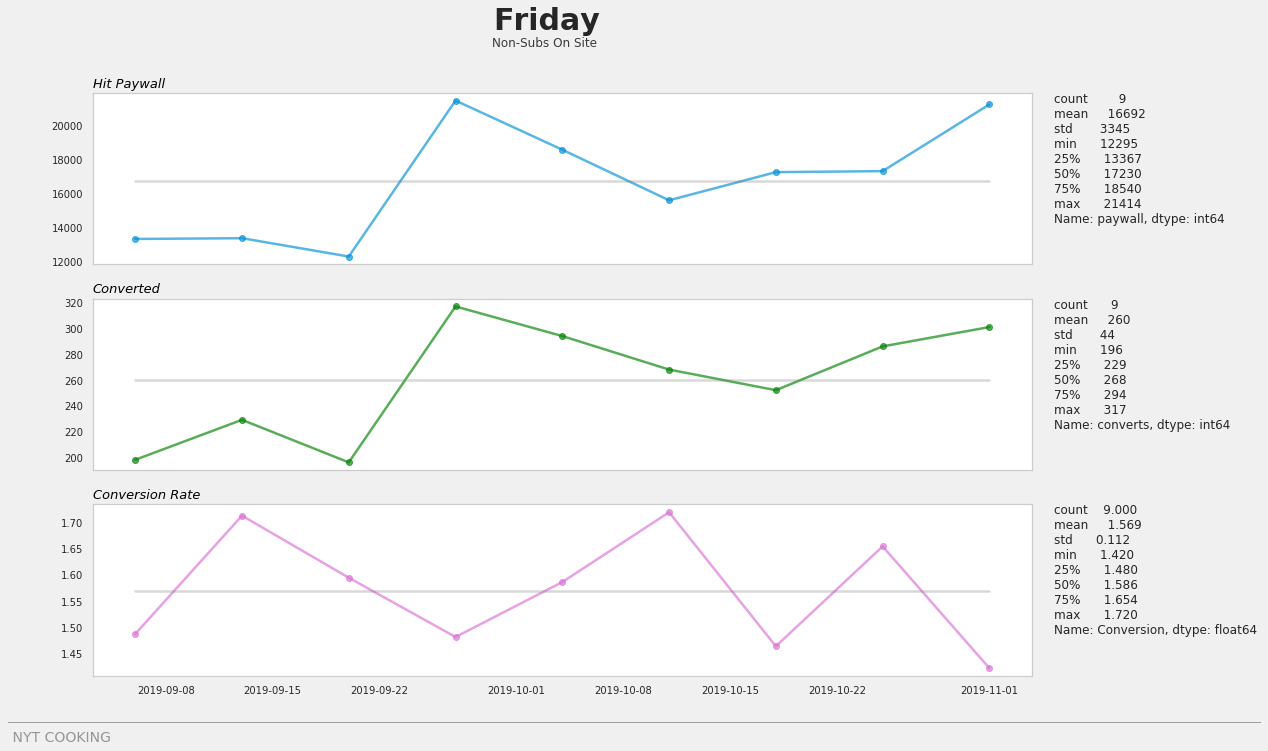

In [84]:
%matplotlib inline
from matplotlib.ticker import MaxNLocator
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 15,10
sb.despine()
#sb.set(font_scale = .8)
sb.set_style("whitegrid", {'axes.grid' : False})
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

#      ---->      Hit paywall and # converted
# dfFri
Fri = dfFri["paywall"].describe().astype(int)
Fri1 = str(Fri)

Fri2 = dfFri["converts"].describe().astype(int)
Fri22 = str(Fri2)

Fri3 = dfFri["Conversion"].describe().round(3)
Fri33 = str(Fri3)

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3)
ax1.plot('day', 'paywall', data=dfFri, marker='o', alpha=0.65)
#average
ax1.plot('day', 'paywallAvg', data=dfFri, alpha=0.30,color='grey')
plt.title('Hit Paywall', fontsize=13, color='black', loc='left', style='italic')
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.tick_params(axis = 'y', which = 'major', labelsize = 10)


ax2 = plt.subplot2grid((3, 3), (1, 0), colspan=3)
ax2.plot('day','converts', data=dfFri, marker='o', color="green", alpha=0.65)
#average
ax2.plot('day', 'convertsAvg', data=dfFri, alpha=0.3,color='grey')
plt.title('Converted', fontsize=13, color='black', loc='left', style='italic')
plt.setp(ax2.get_xticklabels(), visible=False)
ax2.tick_params(axis = 'y', which = 'major', labelsize = 10)

ax3 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
ax3.plot('day','Conversion', data=dfFri, marker='o', color="orchid", alpha=0.65) #turquoise
#average
ax3.plot('day', 'conversionAvg', data=dfFri, alpha=0.3,color='grey')
plt.title('Conversion Rate', fontsize= 13, color='black', loc='left', style='italic')
ax3.tick_params(axis = 'both', which = 'major', labelsize = 10)

plt.suptitle('Friday', y=1.0,fontsize=30,weight='bold')
plt.figtext(.97, .70,Fri1)
plt.figtext(.97, .414,Fri22)
plt.figtext(.97, .13,Fri33)
plt.figtext(x = 0.001, y = .01,
    s = '_________________________________________________________________________________________________________________________________________________________________________________________________________________',
    color = 'grey', alpha = .75)
plt.figtext(x = 0.0013, y = -.020,
    s = ' NYT COOKING',
    fontsize = 14, color = 'grey', alpha = .81)
plt.figtext(x = .45, y = .945,
               s = 'Non-Subs On Site',
              fontsize = 12, alpha = .90)
plt.show()

<h1> Saturday :) <h1> 

In [0]:
dfSat['paywallAvg'] = dfSat['paywall'].mean()
dfSat['convertsAvg'] = dfSat['converts'].mean()
dfSat['conversionAvg'] = dfSat['Conversion'].mean()

dfSat.head(n=6)

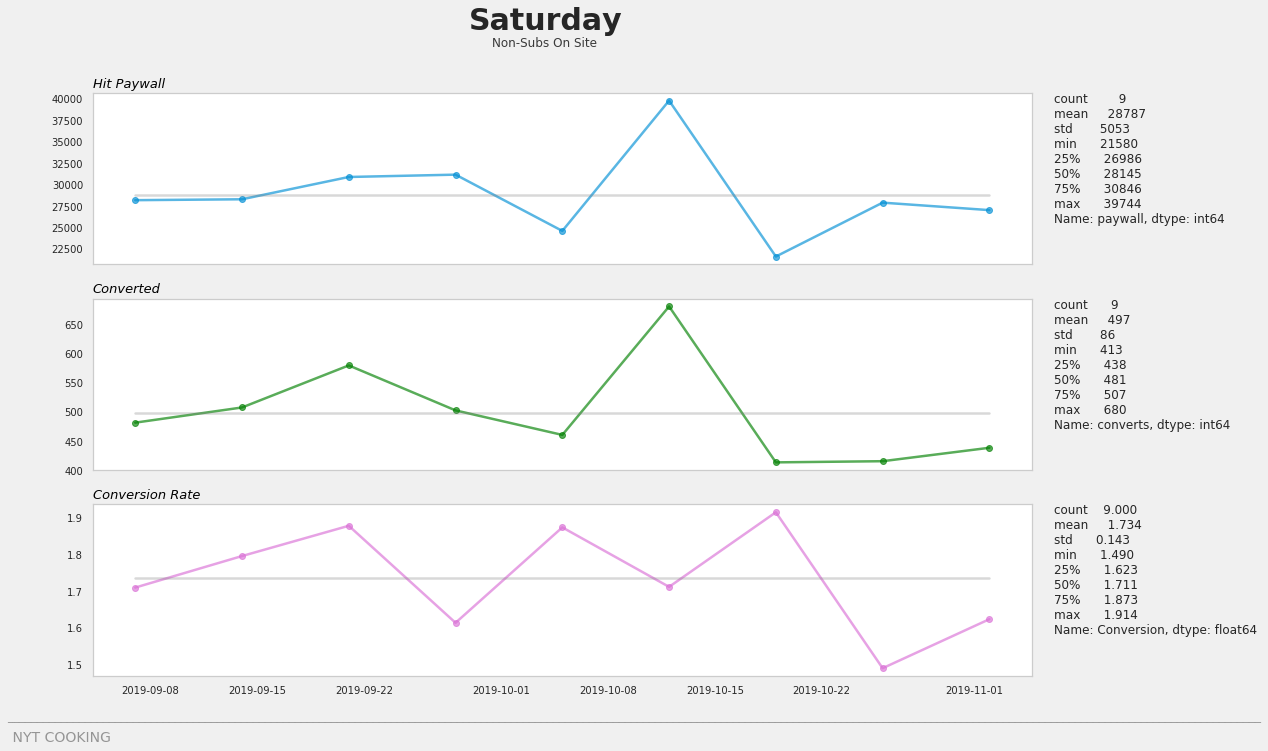

In [86]:
%matplotlib inline
from matplotlib.ticker import MaxNLocator
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 15,10
sb.despine()
#sb.set(font_scale = .8)
sb.set_style("whitegrid", {'axes.grid' : False})
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

#      ---->      Hit paywall and # converted
# dfSat
sat = dfSat["paywall"].describe().astype(int)
s1 = str(sat)

sat2 = dfSat["converts"].describe().astype(int)
sat22 = str(sat2)

sat3 = dfSat["Conversion"].describe().round(3)
sat33 = str(sat3)

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3)
ax1.plot('day', 'paywall', data=dfSat, marker='o', alpha=0.65)
#average
ax1.plot('day', 'paywallAvg', data=dfSat, alpha=0.30,color='grey')
plt.title('Hit Paywall', fontsize=13, color='black', loc='left', style='italic')
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.tick_params(axis = 'y', which = 'major', labelsize = 10)


ax2 = plt.subplot2grid((3, 3), (1, 0), colspan=3)
ax2.plot('day','converts', data=dfSat, marker='o', color="green", alpha=0.65)
#average
ax2.plot('day', 'convertsAvg', data=dfSat, alpha=0.3,color='grey')
plt.title('Converted', fontsize=13, color='black', loc='left', style='italic')
plt.setp(ax2.get_xticklabels(), visible=False)
ax2.tick_params(axis = 'y', which = 'major', labelsize = 10)

ax3 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
ax3.plot('day','Conversion', data=dfSat, marker='o', color="orchid", alpha=0.65) #turquoise
#average
ax3.plot('day', 'conversionAvg', data=dfSat, alpha=0.3,color='grey')
plt.title('Conversion Rate', fontsize= 13, color='black', loc='left', style='italic')
ax3.tick_params(axis = 'both', which = 'major', labelsize = 10)

plt.suptitle('Saturday', y=1.0,fontsize=30,weight='bold')
plt.figtext(.97, .70,s1)
plt.figtext(.97, .414,sat22)
plt.figtext(.97, .13,sat33)
plt.figtext(x = 0.001, y = .01,
    s = '_________________________________________________________________________________________________________________________________________________________________________________________________________________',
    color = 'grey', alpha = .75)
plt.figtext(x = 0.0013, y = -.020,
    s = ' NYT COOKING',
    fontsize = 14, color = 'grey', alpha = .81)
plt.figtext(x = .45, y = .945,
               s = 'Non-Subs On Site',
              fontsize = 12, alpha = .90)
plt.show() 

<h1> Sunday :) <h1> 

In [0]:
dfSun['paywallAvg'] = dfSun['paywall'].mean()
dfSun['convertsAvg'] = dfSun['converts'].mean()
dfSun['conversionAvg'] = dfSun['Conversion'].mean()

dfSun.head(n=6)

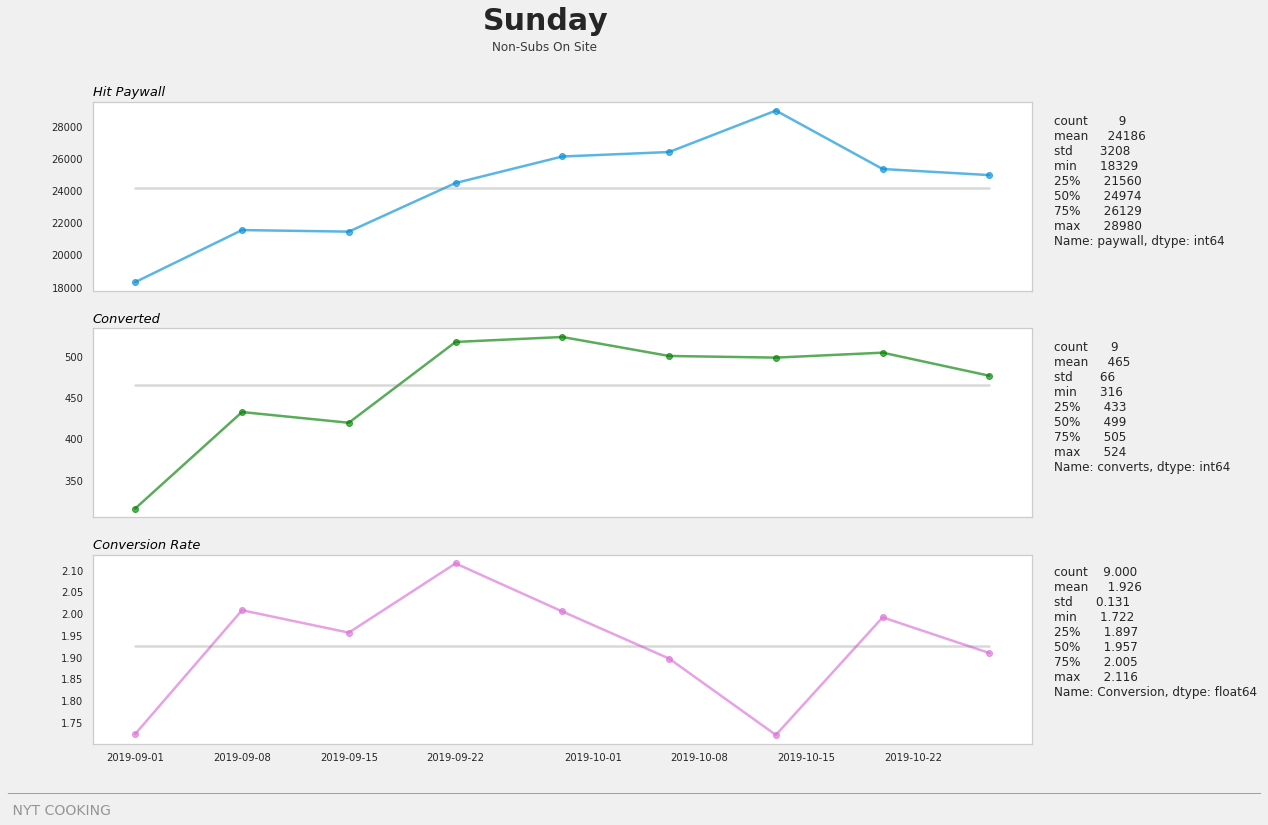

In [88]:
%matplotlib inline
from matplotlib.ticker import MaxNLocator
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 15,11
sb.despine()
#sb.set(font_scale = .8)
sb.set_style("whitegrid", {'axes.grid' : False})
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

#      ---->      Hit paywall and # converted
# dfSun
sun = dfSun["paywall"].describe().astype(int)
sun1 = str(sun)

sun2 = dfSun["converts"].describe().astype(int)
sun22 = str(sun2)

sun3 = dfSun["Conversion"].describe().round(3)
sun33 = str(sun3)
"""
# dfSun
plt.plot( 'day', 'paywall', data=df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot( 'day', 'converts', data=df, marker='', color='olive', linewidth=2)
plt.legend()
plt.title('Sunday',fontsize=25,weight='bold')
plt.xlabel('Day',fontsize=14, weight='bold')
plt.figtext(.96, .5,sun1)
plt.figtext(.96, .15,sun22)
plt.show()
"""

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3)
ax1.plot( 'day', 'paywall', data=dfSun, marker='o', alpha=0.65)
#average
ax1.plot( 'day', 'paywallAvg', data=dfSun, alpha=0.30,color='grey')
plt.title('Hit Paywall', fontsize=13, color='black', loc='left', style='italic')
#plt.ylabel('# hit paywall                       ', fontsize=10, rotation=0, weight='bold')
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.tick_params(axis = 'y', which = 'major', labelsize = 10)
#plt.figtext(.1,.7810,'Average',fontsize=10)


ax2 = plt.subplot2grid((3, 3), (1, 0), colspan=3)
ax2.plot('day','converts', data=dfSun, marker='o', color="green", alpha=0.65)
#average
ax2.plot( 'day', 'convertsAvg', data=dfSun, alpha=0.30,color='grey')
plt.title('Converted', fontsize=13, color='black', loc='left', style='italic')
#plt.ylabel('Converted              ', fontsize=12, rotation=0, weight='bold')
plt.setp(ax2.get_xticklabels(), visible=False)
ax2.tick_params(axis = 'y', which = 'major', labelsize = 10)
#plt.figtext(.1,.5,'Average',fontsize=10)

ax3 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
ax3.plot( 'day','Conversion', data=dfSun, marker='o', color="orchid", alpha=0.65) #turquoise
#average
ax3.plot( 'day', 'conversionAvg', data=dfSun, alpha=0.30,color='grey')
#plt.text(.1,dfSun.conversionAvg.tail(1),'Average',size= 'small')
plt.title('Conversion Rate', fontsize= 13, color='black', loc='left', style='italic')
#plt.ylabel('% Conversion                    ', fontsize=12, rotation=0, weight='bold')
#plt.figtext(.1,.2,'Average',fontsize=10)

ax3.tick_params(axis = 'both', which = 'major', labelsize = 10)
plt.suptitle('Sunday', y=1.0,fontsize=30,weight='bold')

plt.figtext(.97, .70,sun1)
plt.figtext(.97, .414,sun22)
plt.figtext(.97, .13,sun33)
plt.figtext(x = 0.001, y = .01,
    s = '_________________________________________________________________________________________________________________________________________________________________________________________________________________',
    color = 'grey', alpha = .75)
plt.figtext(x = 0.0013, y = -.020,
    s = ' NYT COOKING',
    fontsize = 14, color = 'grey', alpha = .81)
plt.figtext(x = .45, y = .945,
               s = 'Non-Subs On Site',
              fontsize = 12, alpha = .90)
plt.show() 

In [0]:
%matplotlib inline
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 12,7
sb.despine()
#sb.set(font_scale = .8)
sb.set_style("whitegrid", {'axes.grid' : False})
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

# dfSun
sun = dfSun["Conversion"].describe()
sun1 = str(sun)

# dfSun
sb.lineplot(x="day", y="Conversion", data=dfSun)
plt.title('Sunday',fontsize=25,weight='bold')
plt.ylabel('% Conversion               ', fontsize=10, rotation=0, weight='bold')
plt.xlabel('Day',fontsize=14, weight='bold')
plt.figtext(.96, .5,sun1)
plt.show()

In [0]:
def ThresholdForAlerts(df):
  # Take each df segment and print the mean % hit paywall and interval
  
  # Monday
  MondayAverage = np.mean(df[df['dayName'] == 'Monday']["Conversion"])
  MondaySD= np.std(df[df['dayName'] == 'Monday']["Conversion"])
  Mondaylow, MondayHigh = ( MondayAverage - (2*(MondaySD)) ) , ( MondayAverage + (2*(MondaySD)))
  minMon = df[df['dayName'] == 'Monday']["Conversion"].min()

  
  # Tuesday
  TuesdayAverage = np.mean(df[df['dayName'] == 'Tuesday']["Conversion"])
  TuesdaySD = np.std(df[df['dayName'] == 'Tuesday']["Conversion"])
  Tuesdaylow, TuesdayHigh = ( TuesdayAverage - (2*(TuesdaySD)) ) , ( TuesdayAverage + (2*(TuesdaySD)))
  minTue = df[df['dayName'] == 'Tuesday']["Conversion"].min()
  
  # Wednesday
  WedAverage = np.mean(df[df['dayName'] == 'Wednesday']["Conversion"])
  WedSD = np.std(df[df['dayName'] == 'Wednesday']["Conversion"]) 
  Wedlow, WedHigh = ( WedAverage - (2*(WedSD)) ) , ( WedAverage + (2*(WedSD)))
  minWed = df[df['dayName'] == 'Wednesday']["Conversion"].min()
  
  # Thursday
  ThursAverage = np.mean(df[df['dayName'] == 'Thursday']["Conversion"])
  ThursSD = np.std(df[df['dayName'] == 'Thursday']["Conversion"])
  Thurslow, ThursHigh = ( ThursAverage - (2*(ThursSD)) ) , ( ThursAverage + (2*(ThursSD)))
  minThurs = df[df['dayName'] == 'Thursday']["Conversion"].min()
  
  # Friday
  FriAverage = np.mean(df[df['dayName'] == 'Friday']["Conversion"])
  FriSD = np.std(df[df['dayName'] == 'Friday']["Conversion"])
  Frilow, FriHigh = ( FriAverage - (2*(FriSD)) ) , ( FriAverage + (2*(FriSD)))
  minFri = df[df['dayName'] == 'Friday']["Conversion"].min()
  
  # Saturday
  SatAverage = np.mean(df[df['dayName'] == 'Saturday']["Conversion"])
  SatSD = np.std(df[df['dayName'] == 'Saturday']["Conversion"])
  Satlow, SatHigh = ( SatAverage - (2*(SatSD)) ) , ( SatAverage + (2*(SatSD)))
  minSat = df[df['dayName'] == 'Saturday']["Conversion"].min()
  
  # Sunday
  SunAverage = np.mean(df[df['dayName'] == 'Sunday']["Conversion"])
  SunSD = np.std(df[df['dayName'] == 'Sunday']["Conversion"])
  Sunlow, SunHigh = ( SunAverage - (2*(SunSD)) ) , ( SunAverage + (2*(SunSD)))
  minSun = df[df['dayName'] == 'Sunday']["Conversion"].min() 
  
   
  return(print(
            '\n', 
          '----------------------------------------------',
           '\n',
         'Monday Avg:', round(MondayAverage,3),
         '\n',
         'Monday Thresholds:', round(Mondaylow,3), '-', round(MondayHigh,3),
         '\n',
         'Monday min:', round(minMon,3),
         '\n',
         '----------------------------------------------',
         '\n',
               
         'Tuesday Avg:', round(TuesdayAverage,3),
         '\n',
         'Tuesday Thresholds:', round(Tuesdaylow,3), '-', round(TuesdayHigh,3),
         '\n',
         'Tuesday min:', round(minTue,3),
         '\n',
         '----------------------------------------------',
         '\n',
               
         'Wednesday Avg:', round(WedAverage,3),
         '\n',
         'Wednesday Thresholds:', round(Wedlow,3), '-', round(WedHigh,3),
         '\n',
         'Wednesday min:', round(minWed,3),
         '\n',
         '----------------------------------------------',
         '\n',
               
         'Thursday Avg:', round(ThursAverage,3),
         '\n',
         'Thursday Thresholds:', round(Thurslow,3), '-', round(ThursHigh,3),
         '\n',
         'Thursday min:', round(minThurs,3),
         '\n',
         '----------------------------------------------',
         '\n',
               
         'Friday Avg:', round(FriAverage,3),
         '\n',
         'Friday Thresholds:', round(Frilow,3), '-', round(FriHigh,3),
         '\n',
         'Friday min:', round(minFri,3),
         '\n',
         '----------------------------------------------',
         '\n',
               
         'Saturday Avg:', round(SatAverage,3),
         '\n',
         'Saturday Thresholds:', round(Satlow,3), '-', round(SatHigh,3),
         '\n',
         'Saturday min:', round(minSat,3),
         '\n',
         '----------------------------------------------',
         '\n',
               
         'Sunday Avg:', round(SunAverage,3),
         '\n',
         'Sunday Thresholds:', round(Sunlow,3), '-', round(SunHigh,3),
         '\n',
         'Sunday min:', round(minSun,3),
         '\n',
       '----------------------------------------------',
       '\n'
        ))  

In [93]:
# Converson Rate Threshold
ThresholdForAlerts(df)



 ---------------------------------------------- 
 Monday Avg: 1.538 
 Monday Thresholds: 1.17 - 1.906 
 Monday min: 1.215 
 ---------------------------------------------- 
 Tuesday Avg: 1.539 
 Tuesday Thresholds: 1.119 - 1.958 
 Tuesday min: 1.242 
 ---------------------------------------------- 
 Wednesday Avg: 1.487 
 Wednesday Thresholds: 1.081 - 1.893 
 Wednesday min: 1.055 
 ---------------------------------------------- 
 Thursday Avg: 1.607 
 Thursday Thresholds: 1.213 - 2.002 
 Thursday min: 1.108 
 ---------------------------------------------- 
 Friday Avg: 1.569 
 Friday Thresholds: 1.358 - 1.779 
 Friday min: 1.42 
 ---------------------------------------------- 
 Saturday Avg: 1.734 
 Saturday Thresholds: 1.464 - 2.003 
 Saturday min: 1.49 
 ---------------------------------------------- 
 Sunday Avg: 1.926 
 Sunday Thresholds: 1.678 - 2.173 
 Sunday min: 1.722 
 ---------------------------------------------- 

